In [56]:
import numpy as np
from keras.models import load_model
import pandas as pd
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from urllib.request import urlopen
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Sequential, Model
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
data = pd.read_csv('../input/model-vgg19-resnet-classification-product-amazon/data_recommend.csv', index_col = 0)
data_train = pd.read_csv('../input/product-250-amazon/data_250.csv', index_col = 0)
model = load_model('../input/model-vgg19-resnet-classification-product-amazon/vgg19.h5')
image_array = np.load('../input/product-250-amazon/image_array_250.npy')
label_array = np.load('../input/product-250-amazon/label_array_250.npy')

2022-10-06 12:51:57.431627: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [3]:
categories = ['Health & Personal Care',
 'Camera & Photo',
 'Baby',
 'Home Improvement',
 'Patio, Lawn & Garden',
 'Pet Supplies',
 'Home & Kitchen',
 'Arts, Crafts & Sewing',
 'Kitchen & Dining',
 'Automotive',
 'Grocery & Gourmet Food',
 'Musical Instruments',
 'Beauty',
 'Electronics',
 'ComputersComputers',
 'Cell Phones & Accessories',
 'Clothing',
 'Shoes',
 'Jewelry',
 'Watches']

In [4]:
# data.shape

(20982, 5)

In [5]:
# data.drop_duplicates(subset = 'imUrl', inplace = True)

In [6]:

# # data_train.drop_duplicates(subset='imUrl', inplace = True)
# data_train.drop(columns = 'categories', axis = 1, inplace = True)

In [7]:
# data_train

,imUrl
0,http://ecx.images-amazon.com/images/I/51HRq6re...
1,http://ecx.images-amazon.com/images/I/3161EYR6...
2,http://ecx.images-amazon.com/images/I/11B4HMY1...
3,http://ecx.images-amazon.com/images/I/51dGkqI8...
4,http://ecx.images-amazon.com/images/I/51ZEM114...
...,...
4995,http://ecx.images-amazon.com/images/I/41hTMIVi...
4996,http://ecx.images-amazon.com/images/I/51wDh-Gx...
4997,http://ecx.images-amazon.com/images/I/512KIYUt...
4998,http://ecx.images-amazon.com/images/I/516ZXV33...


In [8]:
# df = data_train.merge(data, how = 'left', on ='imUrl')
# df.shape

(5000, 5)

In [27]:
df.head()

,imUrl,ProductID,title,brand,categories,image
0,http://ecx.images-amazon.com/images/I/51HRq6re...,B000052YAQ,"Reach Gentle Gum Care, Mint Woven Floss, Fluor...",No Brand,Health & Personal Care,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,http://ecx.images-amazon.com/images/I/3161EYR6...,B0000530TR,"Nature's Resource Echinacea, 350 mg (240 Capsu...",No Brand,Health & Personal Care,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,http://ecx.images-amazon.com/images/I/11B4HMY1...,B000052XA8,"Sure Antiperspirant &amp; Deodorant Roll-On, U...",No Brand,Health & Personal Care,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,http://ecx.images-amazon.com/images/I/51dGkqI8...,B000050B6B,Philips Norelco HQ5 Shaving Heads,Philips,Health & Personal Care,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,http://ecx.images-amazon.com/images/I/51ZEM114...,B00003IEM8,Energizer-Eveready 05669 E92BP-8 AAA Battery,Energizer,Health & Personal Care,"[[[245, 246, 251], [245, 246, 251], [245, 246,..."


In [48]:
df.drop([4222,4185 ], axis=0, inplace = True)

In [51]:
df.reset_index(drop = True, inplace = True)

In [52]:
# load the model
vgg_model = vgg16.VGG16(weights='imagenet')

# remove the last layers in order to get features instead of predictions
feat_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.get_layer("fc2").output)

# print the layers of the CNN
feat_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [53]:
from tensorflow.keras.applications.imagenet_utils import preprocess_input
importedImages=[]
for img in df['image']:
    #Convert the images to array
    image_batch = np.expand_dims(img, axis=0)
    importedImages.append(image_batch)
    
images = np.vstack(importedImages)

processed_imgs = preprocess_input(images.copy())

In [54]:
imgs_features = feat_extractor.predict(processed_imgs)

print("features successfully extracted!")
imgs_features.shape

2022-10-06 13:45:35.023620: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


features successfully extracted!


(4998, 4096)

In [57]:
# compute cosine similarities between images

cosSimilarities = cosine_similarity(imgs_features)

# store the results into a pandas dataframe

cos_similarities_df = pd.DataFrame(cosSimilarities, columns=df['ProductID'], index=df['ProductID'])
cos_similarities_df

ProductID,B000052YAQ,B0000530TR,B000052XA8,B000050B6B,B00003IEM8,8921422544,B000052YAD,441003006X,7538626107,B000052XNQ,...,B00013WATA,B00030BQT6,B0001YMVTS,B0000TFVLE,B0002UD56O,B00011U2LA,B00022AALA,B0006GN9J2,B00015GLY8,B00020ODFG
ProductID,,,,,,,,,,,,,,,,,,,,,
B000052YAQ,1.000000,0.616657,0.623562,0.441351,0.541439,0.237632,0.740059,0.581569,0.300597,0.796645,...,0.283955,0.150213,0.330578,0.322492,0.231521,0.227950,0.181368,0.174869,0.215758,0.315840
B0000530TR,0.616657,1.000000,0.594615,0.282757,0.372892,0.141492,0.455001,0.371667,0.205953,0.544680,...,0.186627,0.097399,0.196386,0.165613,0.170276,0.113172,0.090843,0.111988,0.175524,0.209241
B000052XA8,0.623562,0.594615,1.000000,0.338627,0.441118,0.284273,0.636850,0.592299,0.231692,0.587192,...,0.294702,0.153484,0.265770,0.239339,0.250898,0.186498,0.128666,0.146919,0.245947,0.269627
B000050B6B,0.441351,0.282757,0.338627,1.000000,0.368910,0.223048,0.404650,0.390648,0.313690,0.432383,...,0.425950,0.305921,0.443745,0.367666,0.380629,0.402131,0.298353,0.308003,0.328392,0.408381
B00003IEM8,0.541439,0.372892,0.441118,0.368910,1.000000,0.262119,0.479097,0.458092,0.347808,0.569451,...,0.222959,0.128675,0.216109,0.200505,0.277653,0.176939,0.112003,0.149115,0.165196,0.244672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00011U2LA,0.227950,0.113172,0.186498,0.402131,0.176939,0.216486,0.176200,0.270817,0.153274,0.165379,...,0.484290,0.634655,0.526595,0.584802,0.608031,1.000000,0.657397,0.580937,0.585395,0.581709
B00022AALA,0.181368,0.090843,0.128666,0.298353,0.112003,0.100871,0.135619,0.172062,0.115318,0.119757,...,0.476691,0.750269,0.592922,0.583872,0.490409,0.657397,1.000000,0.737657,0.580482,0.494242
B0006GN9J2,0.174869,0.111988,0.146919,0.308003,0.149115,0.113000,0.140410,0.237655,0.160321,0.141275,...,0.461308,0.719039,0.490157,0.486632,0.521715,0.580937,0.737657,1.000000,0.624477,0.530152


In [58]:
imgs_model_width, imgs_model_height = 224,224

In [78]:
import re
def image_recommend_1(pid,num_recommend = 5):
    
    """
    PID: Product ID of the original item in our dataset
    num_recommend : Number of most similar images to retrieve
    
    """
    
#     given_img=df['Images'][df['PID']==pid].item()
#     given_img =  './oooo.jpg'
#     #Displaying the original product- Image, PID, Name, Brand
    plt.figure(figsize=(2, 1.5), dpi=80)
    plt.imshow(df.image[pid])
    plt.show()
    
    print("-----------------------------------------------------------------------")
    print("Original product:")
    print("-----------------------------------------------------------------------")
    
    print("\nProduct ID : ",df['ProductID'][pid])
    print("Title : ",df.title[pid])
    print("Brand : ",df.categories[pid])
    print("link : ",df.imUrl[pid])

#     cos_similarities_df_copy = cos_similarities_df.copy()
    
    
    # getting the indexes and scores of the N most similar products
    closest_imgs = cos_similarities_df.sort_values(df['ProductID'][pid],ascending=False)[1:num_recommend+1].index
    closest_imgs_scores = cos_similarities_df[df['ProductID'][pid]].sort_values(ascending=False)[1:num_recommend+1]

    
    _re_digits = re.compile(r'\d+') #We use regex to extract only the pids from file names
    closest_imgs_pid = []
    for element in closest_imgs:
        print(element)
        closest_imgs_pid += [int(n) for n in _re_digits.findall(element)]
    
    # Displaying the recommended products- Image, PID, Name, Brand and Similarity Score

    print("-----------------------------------------------------------------------")
    print("Most similar products:")
    print("-----------------------------------------------------------------------") 
    
    list_link = []
    for i in closest_imgs:
        print("\nProduct ID : ",i)
        print("Title : ",df.loc[df['ProductID']==i].reset_index(drop=True).title[0])
        print("Brand : ",df.loc[df['ProductID']==i].reset_index(drop=True).categories[0])
        list_link.append(df.loc[df['ProductID']==i].reset_index(drop=True).imUrl[0])
        print("link : ",df.loc[df['ProductID']==i].reset_index(drop=True).imUrl[0])
        print("similarity score : ",closest_imgs_scores[i])

        # we get the url of the apparel and download it
        print(i)
#         df_rcm['image'][0]
        img = df.loc[df['ProductID']==i].reset_index(drop=True).image[0]
        plt.figure(figsize=(2, 1.5), dpi=80)
        plt.imshow(img)
        plt.show()
#     for i in list_link:
#         print(i)

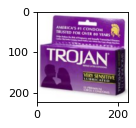

-----------------------------------------------------------------------
Original product:
-----------------------------------------------------------------------

Product ID :  B000052XL5
Title :  Trojan Very Sensitive Lubricated Latex Condoms - 12 ea
Brand :  Health & Personal Care
link :  http://ecx.images-amazon.com/images/I/319XAN19JJL.jpg
B000052XJT
B000052WR0
B000052XIH
B000E40R7S
B0000532I3
-----------------------------------------------------------------------
Most similar products:
-----------------------------------------------------------------------

Product ID :  B000052XJT
Title :  Trojan Magnum Premium Latex Condoms, Lubricated, Large Size , 12 condoms
Brand :  Health & Personal Care
link :  http://ecx.images-amazon.com/images/I/31HGWX9B60L.jpg
similarity score :  0.86521983
B000052XJT


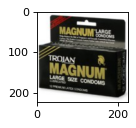


Product ID :  B000052WR0
Title :  Flex-All Plus Max Strength Topical Analgesic Gel, 4-ounce Tube
Brand :  Health & Personal Care
link :  http://ecx.images-amazon.com/images/I/21081AVG5HL.jpg
similarity score :  0.8117003
B000052WR0


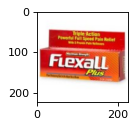


Product ID :  B000052XIH
Title :  Ortho Options Vaginal Contraceptive Foam with Applicator  0.6 oz (17 g)
Brand :  Health & Personal Care
link :  http://ecx.images-amazon.com/images/I/21QG6EZWQKL.jpg
similarity score :  0.80294424
B000052XIH


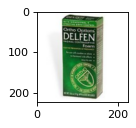


Product ID :  B000E40R7S
Title :  Transcend 128MB microSD Card - Black (TS128MUSD)
Brand :  ComputersComputers
link :  http://ecx.images-amazon.com/images/I/41MA15Q1DHL._SY300_.jpg
similarity score :  0.7781249
B000E40R7S


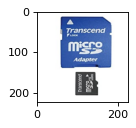


Product ID :  B0000532I3
Title :  Depend Undergarments, Regular Absorbency - 36 ea
Brand :  Health & Personal Care
link :  http://ecx.images-amazon.com/images/I/2186EXCJP9L.jpg
similarity score :  0.77653646
B0000532I3


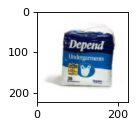

In [79]:
image_recommend_1(10,5)